<a href="https://colab.research.google.com/github/EduBarseghian/ADDI_Barseghian/blob/main/02_ADDI_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.max_columns=30

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

!pip install fast_ml
from fast_ml.model_development import train_valid_test_split

     |████████████████████████████████| 42 kB 443 kB/s 


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
url = "https://raw.githubusercontent.com/EduBarseghian/ADDI_Barseghian/main/default_of_credit_card_clients.xls"
df = pd.read_excel(url, index_col=0)
df.columns = df.iloc[0]
df = df.iloc[1: , :]


numeric_cols = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
                'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
               ]

ordered_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'AGE']

categoric_cols = ['SEX', 'EDUCATION', 'MARRIAGE']

target_col = ['default payment next month']

df[numeric_cols] = df[numeric_cols].astype(float)
df[ordered_cols + categoric_cols + target_col] = df[ordered_cols + categoric_cols + target_col].astype(int)

## Para luego aplicar búsqueda de hiperparámetros con más comodidas, vamos a intercambiar los dos valores de la variable target. De 0 a 1 y de 1 a 0.

In [ ]:
df[target_col]=df[target_col].apply(lambda s: 1-s)

In [ ]:
df.head(3)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [ ]:
# Las variables categóricas vinieron encodeadas de entrada.
X = df.drop(columns=target_col)
y = df[target_col]

***Train test split***

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(df, target = 'default payment next month', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state=0)

***Escalado.***

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Al ser un problema e clasificación entrenamos una regresión logística y un Random Forest.

## Entrenamos una regresión logística

In [ ]:
model_name='LogReg'
reg_model = LogisticRegression(penalty='none')
reg_model.fit(X_train_scaled,y_train)
print(f'{model_name} accuracy score: {reg_model.score(X_val_scaled,y_val):.4}\n')

LogReg accuracy score: 0.827



# Entrenamos un Random Forest

In [ ]:
test=False
model_name="RF"

my_model = RandomForestClassifier()
my_model.fit(X_train_scaled,y_train)
print(f'{model_name} accuracy score: {my_model.score(X_val_scaled,y_val):.4}\n')

RF accuracy score: 0.8323



Seguimos analizando a partir del RF porque dio un poquito mejor, simplemente.

              precision    recall  f1-score   support

           0       0.46      0.12      0.18       617
           1       0.81      0.96      0.88      2383

    accuracy                           0.79      3000
   macro avg       0.63      0.54      0.53      3000
weighted avg       0.74      0.79      0.74      3000



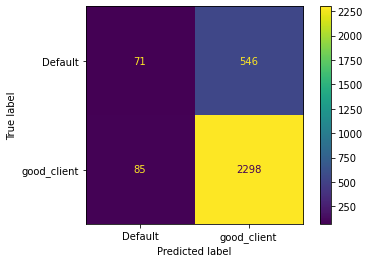

In [ ]:
# Predecimos y graficamos la matriz de reporte
y_train_pred = my_model.predict(X_train)
y_val_pred = my_model.predict(X_val)

print(classification_report(y_val, y_val_pred))
plot_confusion_matrix(my_model, X_val ,y_val, display_labels=['Default', 'good_client'])

## ELECCIÓN de MÉTRICA

En este tipo de problema, además de tener buena Accuracy, se quiere minimizar la cantidad de clientes que el modelo erróneamente predice que no defaultearan.

Esto se traduce a querer minimizar la entrada de abajo a la izquierda de la matriz de confusión (en el ejmplo de arriba, el 536, que no es un valor deseado).

### Si:

A = true positives = godd_clients bien predecidos

D = true negatives = defaulters bien predecidos

B = false negatives = good_clients como defaulteadores

C = false positives = defaulteadores predecidos como good_clients

### Entonces

1) A + B es constante, es la cantidad de clientes cumplidores (aquí, 2383)

2) C + D es constante, es la cantidad de defaulteadores (aqu´, 617)

3) A+B+C+D = 3000, el tamaño del conjunto de validación

Queremos maximizar A + D (las predicciones correctas), y al mismo tiempo minimizar C (en realidad queremos minimizar B y C, pero un poco más C).

Pero minimizar C es maximizar D pues la suma de ambas es constante. Luego, buscamos maximizar A y minimizar C. Esto equivale a maximizar $\frac{A}{A+C}$

En nuestro caso, sirve precision_score de sklearn :


In [ ]:
precision_score(y_val, y_val_pred)

0.8080168776371308

### Invertimos los valores de la variable target porque era necesario el parámetro pos_label en la precision_score, pero a su vez no era tan fácil especificarlo en la búsqueda de hiperparámetros del modelo.

In [ ]:
#precision_score(y_val, y_val_pred, pos_label=0)

## Búsqueda de hiperparámetros

In [ ]:
# Define parameter values that should be searched
bootstrap = [True, False]
max_features = ['auto','sqrt']
min_samples_leaf = [1,2,4]
min_samples_split = [2,5,10]
n_estimators = [50,100,150,200]
max_depth = [4,6,10,12, None]

# Specify "parameter distributions" rather than a "parameter grid"
param_dist = dict(n_estimators=n_estimators, max_depth = max_depth, bootstrap=bootstrap,
                  min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split,
                  max_features=max_features)

# n_iter controls the number of searches

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=10, scoring="precision",
                          n_iter=10, random_state=42)
rand.fit(X_train_scaled, y_train)

# Uncomment line below to print
# rand.cv_results_

def get_best_model(model_grid):
    best_k = model_grid.cv_results_['rank_test_score'][0]
    print (f"Mean score: {model_grid.cv_results_['mean_test_score'][best_k]}",
           f"Std: {model_grid.cv_results_['std_test_score'][best_k]}")
           
# Examine the best model
print("Precision del mejor modelo:")
print(rand.best_score_)
print(rand.best_params_)
get_best_model(rand)

0.8399093770712485
{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Mean score: 0.8376134746206537 Std: 0.003689954556321837


In [ ]:
model_name="best_RF"

best_rf_model = RandomForestClassifier(n_estimators= 150, min_samples_split= 2, min_samples_leaf= 1, max_features="auto", max_depth=None, bootstrap= True)
best_rf_model.fit(X_train_scaled,y_train)
print(f'{model_name} accuracy score: {best_rf_model.score(X_val_scaled,y_val):.4}\n')

best_RF accuracy score: 0.8313

